# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [23]:
import numpy as np
import os
# import imageio
# from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
from skimage.transform import resize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [24]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [25]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [26]:
!unzip "/content/gdrive/MyDrive/Project_data.zip" -d "/content/gdrive/MyDrive/assignment"

Streaming output truncated to the last 5000 lines.
 extracting: /content/gdrive/MyDrive/assignment/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00050.png  
 extracting: /content/gdrive/MyDrive/assignment/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00052.png  
 extracting: /content/gdrive/MyDrive/assignment/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00054.png  
 extracting: /content/gdrive/MyDrive/assignment/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00056.png  
 extracting: /content/gdrive/MyDrive/assignment/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00058.png  
 extracting: /content/gdrive/MyDrive/assignment/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00060.png  
 extracting: /content/gdrive/MyDrive/assignment/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_201

In [27]:
train_doc = np.random.permutation(open('/content/gdrive/MyDrive/assignment/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/gdrive/MyDrive/assignment/Project_data/val.csv').readlines())
batch_size = 32 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [28]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [2,3,4,6,7,8,10,12,14,15,16,18,19,22,23,24,26,27,28,29]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,20,84,84,3))
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = plt.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    image = image[:,20:,:]
                    #resizing the image
                    image = resize(image,(84,84,3), mode='constant', anti_aliasing=True)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if(len(t)%batch_size) != 0:
            batch_data = np.zeros((batch_size,20,84,84,3))
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = plt.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    image = image[:,20:,:]
                    #resizing the image
                    image = resize(image,(84,84,3), mode='constant', anti_aliasing=True)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [29]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/gdrive/MyDrive/assignment/Project_data/train'
val_path = '/content/gdrive/MyDrive/assignment/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [30]:
from keras.models import Sequential, Model
from keras.layers import Dense,Dropout, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l2


#write your model here
model = Sequential()
model.add(Conv3D(32, (3, 3,3), padding='same',input_shape=[20, 84, 84, 3]))
model.add(Activation('relu'))
model.add(Conv3D(32, (3, 3,3)))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv3D(64, (3, 3,3), padding='same'))
model.add(Activation('relu'))
model.add(Conv3D(64, (3, 3,3)))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [31]:
optimiser =  'adam'#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 20, 84, 84, 32)    2624      
_________________________________________________________________
activation_6 (Activation)    (None, 20, 84, 84, 32)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 18, 82, 82, 32)    27680     
_________________________________________________________________
activation_7 (Activation)    (None, 18, 82, 82, 32)    0         
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 9, 41, 41, 32)     0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 9, 41, 41, 32)     128       
_________________________________________________________________
dropout_7 (Dropout)          (None, 9, 41, 41, 32)    

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [32]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [50]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

 # write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.1, min_lr=0)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [51]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
# model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /content/gdrive/MyDrive/assignment/Project_data/train ; batch size = 32
Epoch 1/10
 5/21 [======>.......................] - ETA: 10:11 - loss: 1.9901 - categorical_accuracy: 0.3133

In [35]:
# Model number 2
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Dropout,Activation,LSTM


n_frames = 20
num_epochs = 30
batch_size = 32

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
twoD = tuple([3]*2)
twoD2 = tuple([2]*2)
             

model_2 = Sequential()

model_2.add(TimeDistributed(Conv2D(16, twoD, padding='same', activation='relu'), input_shape=[20, 84, 84, 3]))
model_2.add(TimeDistributed(BatchNormalization()))
model_2.add(TimeDistributed(MaxPooling2D(twoD2)))
model_2.add(TimeDistributed(Conv2D(32, twoD, padding='same', activation='relu')))
model_2.add(TimeDistributed(BatchNormalization()))
model_2.add(TimeDistributed(MaxPooling2D(twoD2)))
model_2.add(TimeDistributed(Conv2D(64, twoD, padding='same', activation='relu')))
model_2.add(TimeDistributed(BatchNormalization()))
model_2.add(TimeDistributed(MaxPooling2D(twoD2)))
model_2.add(TimeDistributed(Conv2D(128, twoD, padding='same', activation='relu')))
model_2.add(TimeDistributed(BatchNormalization()))
model_2.add(TimeDistributed(MaxPooling2D(twoD2)))
model_2.add(TimeDistributed(Conv2D(256, twoD, padding='same', activation='relu')))
model_2.add(TimeDistributed(BatchNormalization()))
model_2.add(TimeDistributed(MaxPooling2D(twoD2)))
model_2.add(TimeDistributed(Flatten()))
model_2.add(LSTM(256))
model_2.add(Dropout(0.2))
model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.2))
model_2.add(Dense(5, activation='softmax'))
model_2.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_2.summary())

Model: "conv_2d_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_50 (TimeDis (None, 20, 84, 84, 16)    448       
_________________________________________________________________
time_distributed_51 (TimeDis (None, 20, 84, 84, 16)    64        
_________________________________________________________________
time_distributed_52 (TimeDis (None, 20, 42, 42, 16)    0         
_________________________________________________________________
time_distributed_53 (TimeDis (None, 20, 42, 42, 32)    4640      
_________________________________________________________________
time_distributed_54 (TimeDis (None, 20, 42, 42, 32)    128       
_________________________________________________________________
time_distributed_55 (TimeDis (None, 20, 21, 21, 32)    0         
_________________________________________________________________
time_distributed_56 (TimeDis (None, 20, 21, 21, 64)   

In [36]:

model_2_history = model_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Source path =  /content/gdrive/MyDrive/assignment/Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - 192s 9s/step - loss: 1.4728 - categorical_accuracy: 0.3744 - val_loss: 1.6422 - val_categorical_accuracy: 0.2344

Epoch 00001: saving model to model_init_2021-06-2804_42_31.466197/model-00001-1.33871-0.43452-1.64217-0.23438.h5
Epoch 2/30
21/21 [==============================] - 185s 9s/step - loss: 1.0328 - categorical_accuracy: 0.5603 - val_loss: 1.8520 - val_categorical_accuracy: 0.2031

Epoch 00002: saving model to model_init_2021-06-2804_42_31.466197/model-00002-1.03795-0.56399-1.85197-0.20312.h5
Epoch 3/30
21/21 [==============================] - 182s 9s/step - loss: 0.9066 - categorical_accuracy: 0.6439 - val_loss: 2.3631 - val_categorical_accuracy: 0.1953

Epoch 00003: saving model to model_init_2021-06-2804_42_31.466197/model-00003-0.87537-0.65030-2.36306-0.19531.h5
Epoch 4/30
21/21 [==============================] - 171s 9s/step - loss: 0.7

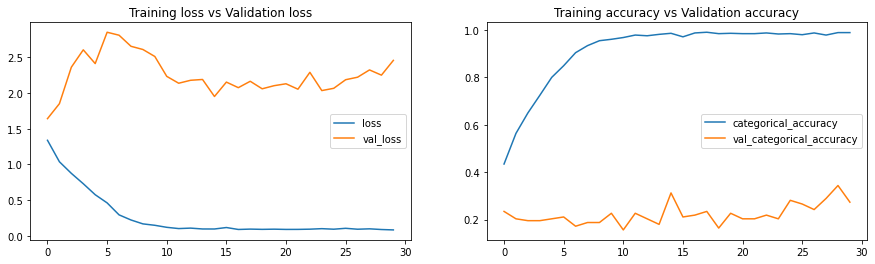

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(15,4))
ax[0].plot(model_2_history.history['loss'])   
ax[0].plot(model_2_history.history['val_loss'])
ax[0].legend(['loss','val_loss'])
ax[0].title.set_text("Training loss vs Validation loss")

ax[1].plot(model_2_history.history['categorical_accuracy'])   
ax[1].plot(model_2_history.history['val_categorical_accuracy'])
ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
ax[1].title.set_text("Training accuracy vs Validation accuracy")
plt.show()

In [72]:
# # Model Number 3

from keras.models import Sequential, Model
from keras.layers import Dense,Dropout, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l2


#write your model here
model_3 = Sequential()
model_3.add(Conv3D(8, (3, 3,3), padding='same',
                 input_shape=[20, 84, 84, 3]))
model_3.add(Activation('relu'))
model_3.add(Conv3D(16, (3, 3,3)))
model_3.add(Activation('relu'))
model_3.add(MaxPooling3D(pool_size=(2, 2,2)))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.25))

model_3.add(Conv3D(32, (3, 3,3), padding='same'))
model_3.add(Activation('relu'))
model_3.add(Conv3D(32, (3, 3,3)))
model_3.add(Activation('relu'))
model_3.add(MaxPooling3D(pool_size=(2, 2,2)))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.25))

model_3.add(Flatten())
model_3.add(Dense(64))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(5))
model_3.add(Activation('softmax'))

In [73]:
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_3.summary())


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_57 (Conv3D)           (None, 20, 84, 84, 8)     656       
_________________________________________________________________
activation_36 (Activation)   (None, 20, 84, 84, 8)     0         
_________________________________________________________________
conv3d_58 (Conv3D)           (None, 18, 82, 82, 16)    3472      
_________________________________________________________________
activation_37 (Activation)   (None, 18, 82, 82, 16)    0         
_________________________________________________________________
max_pooling3d_45 (MaxPooling (None, 9, 41, 41, 16)     0         
_________________________________________________________________
batch_normalization_66 (Batc (None, 9, 41, 41, 16)     64        
_________________________________________________________________
dropout_43 (Dropout)         (None, 9, 41, 41, 16)   

In [43]:
# model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
# if not os.path.exists(model_name):
#     os.mkdir(model_name)
        
# filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

#  # write the REducelronplateau code here
# LR = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.1, min_lr=0)
# callbacks_list = [checkpoint, LR]

In [44]:
# if (num_train_sequences%batch_size) == 0:
#     steps_per_epoch = int(num_train_sequences/batch_size)
# else:
#     steps_per_epoch = (num_train_sequences//batch_size) + 1

# if (num_val_sequences%batch_size) == 0:
#     validation_steps = int(num_val_sequences/batch_size)
# else:
#     validation_steps = (num_val_sequences//batch_size) + 1

In [74]:
num_epochs = 20
model_3_history = model_3.fit(train_generator,  steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                                           callbacks=callbacks_list,  validation_data=val_generator, validation_steps=validation_steps, class_weight=None,
                                           workers=1, initial_epoch=0)


Epoch 1/20
21/21 [==============================] - 186s 9s/step - loss: 1.4406 - categorical_accuracy: 0.3701 - val_loss: 1.7722 - val_categorical_accuracy: 0.1797

Epoch 00001: saving model to model_init_2021-06-2804_42_31.466197/model-00001-1.28899-0.45982-1.77216-0.17969.h5
Epoch 2/20
21/21 [==============================] - 175s 9s/step - loss: 0.9747 - categorical_accuracy: 0.6468 - val_loss: 1.7123 - val_categorical_accuracy: 0.2188

Epoch 00002: saving model to model_init_2021-06-2804_42_31.466197/model-00002-0.87573-0.66220-1.71225-0.21875.h5
Epoch 3/20
21/21 [==============================] - 168s 8s/step - loss: 0.6703 - categorical_accuracy: 0.7261 - val_loss: 1.7869 - val_categorical_accuracy: 0.2109

Epoch 00003: saving model to model_init_2021-06-2804_42_31.466197/model-00003-0.61661-0.76488-1.78691-0.21094.h5
Epoch 4/20
21/21 [==============================] - 177s 9s/step - loss: 0.4843 - categorical_accuracy: 0.8229 - val_loss: 1.8840 - val_categorical_accuracy: 0.171

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(15,4))
ax[0].plot(model_3_history.history['loss'])   
ax[0].plot(model_3_history.history['val_loss'])
ax[0].legend(['loss','val_loss'])
ax[0].title.set_text("Training loss vs Validation loss")

ax[1].plot(model_3_history.history['categorical_accuracy'])   
ax[1].plot(model_3_history.history['val_categorical_accuracy'])
ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
ax[1].title.set_text("Training accuracy vs Validation accuracy")
plt.show()

In [84]:
# Model number 4

model_4 = Sequential()
model_4.add(Conv3D(16, (3,3,3), padding='same', activation='relu', input_shape=[20, 84, 84, 3]))
model_4.add(MaxPooling3D((2), padding='same'))
model_4.add(BatchNormalization())

model_4.add(Conv3D(32, (3,3,3), padding='same', activation='relu'))
model_4.add(MaxPooling3D(pool_size=(2), padding='same'))
model_4.add(BatchNormalization())

model_4.add(Conv3D(64, (3,3,3), padding='same', activation='relu'))
model_4.add(MaxPooling3D(pool_size=(2), padding='same'))
model_4.add(BatchNormalization())

model_4.add(Conv3D(128, (3,3,3), padding='same', activation='relu'))
model_4.add(MaxPooling3D(pool_size=(2), padding='same'))
model_4.add(BatchNormalization())

model_4.add(Flatten())
model_4.add(Dense(128, activation='relu'))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.5))

model_4.add(Dense(64, activation='relu'))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.5))

model_4.add(Dense(5, activation='softmax'))

In [86]:
model_4.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_4.summary())

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_69 (Conv3D)           (None, 20, 84, 84, 16)    1312      
_________________________________________________________________
max_pooling3d_53 (MaxPooling (None, 10, 42, 42, 16)    0         
_________________________________________________________________
batch_normalization_75 (Batc (None, 10, 42, 42, 16)    64        
_________________________________________________________________
conv3d_70 (Conv3D)           (None, 10, 42, 42, 32)    13856     
_________________________________________________________________
max_pooling3d_54 (MaxPooling (None, 5, 21, 21, 32)     0         
_________________________________________________________________
batch_normalization_76 (Batc (None, 5, 21, 21, 32)     128       
_________________________________________________________________
conv3d_71 (Conv3D)           (None, 5, 21, 21, 64)   

In [87]:
model_4_history = model_4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
21/21 [==============================] - 173s 8s/step - loss: 2.0602 - categorical_accuracy: 0.3309 - val_loss: 2.5914 - val_categorical_accuracy: 0.1641

Epoch 00001: saving model to model_init_2021-06-2804_42_31.466197/model-00001-1.95827-0.33780-2.59136-0.16406.h5
Epoch 2/20
21/21 [==============================] - 169s 8s/step - loss: 1.5856 - categorical_accuracy: 0.4196 - val_loss: 3.1947 - val_categorical_accuracy: 0.1719

Epoch 00002: saving model to model_init_2021-06-2804_42_31.466197/model-00002-1.47093-0.46577-3.19471-0.17188.h5
Epoch 3/20
21/21 [==============================] - 170s 9s/step - loss: 1.2031 - categorical_accuracy: 0.5661 - val_loss: 3.9416 - val_categorical_accuracy: 0.1484

Epoch 00003: saving model to model_init_2021-06-2804_42_31.466197/model-00003-1.20736-0.54167-3.94156-0.14844.h5
Epoch 4/20
21/21 [==============================] - 168s 8s/step - loss: 1.0035 - categorical_accuracy: 0.6327 - val_loss: 4.1539 - val_categorical_accuracy: 0.156

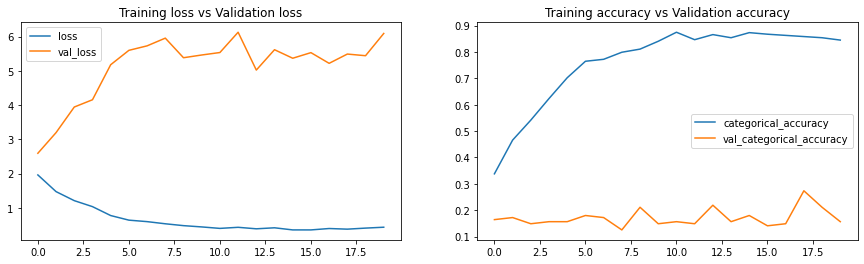

In [88]:
fig, ax = plt.subplots(1, 2, figsize=(15,4))
ax[0].plot(model_4_history.history['loss'])   
ax[0].plot(model_4_history.history['val_loss'])
ax[0].legend(['loss','val_loss'])
ax[0].title.set_text("Training loss vs Validation loss")

ax[1].plot(model_4_history.history['categorical_accuracy'])   
ax[1].plot(model_4_history.history['val_categorical_accuracy'])
ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
ax[1].title.set_text("Training accuracy vs Validation accuracy")
plt.show()

In [92]:
# model number 5 with GRU
model_5 = Sequential()
        
model_5.add(TimeDistributed(Conv2D(32, (1, 1), padding='same'), input_shape=[20, 84, 84, 3]))
model_5.add(TimeDistributed(Activation('relu')))
model_5.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
model_5.add(TimeDistributed(BatchNormalization()))

model_5.add(TimeDistributed(Conv2D(32, (3, 3), padding='same')))
model_5.add(TimeDistributed(Activation('relu')))
model_5.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
model_5.add(TimeDistributed(BatchNormalization()))

model_5.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
model_5.add(TimeDistributed(Activation('relu')))
model_5.add(TimeDistributed(BatchNormalization()))
model_5.add(Dropout(0.25))

model_5.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
model_5.add(TimeDistributed(Activation('relu')))
model_5.add(TimeDistributed(MaxPooling2D((3, 3))))

model_5.add(TimeDistributed(Conv2D(64, (3, 3), padding='same')))
model_5.add(TimeDistributed(Activation('relu')))        
model_5.add(Dropout(0.25))

model_5.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
model_5.add(TimeDistributed(Activation('relu')))
model_5.add(Dropout(0.50))

model_5.add(TimeDistributed(Conv2D(256, (5, 5), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
model_5.add(TimeDistributed(Activation('relu')))

model_5.add(TimeDistributed(Flatten()))
        
model_5.add(Dense(16))
model_5.add(Dropout(.50))
model_5.add(GRU(64, return_sequences=False))        

model_5.add(Dense(5, activation='softmax'))

In [93]:
model_5.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_5.summary())

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_69 (Conv3D)           (None, 20, 84, 84, 16)    1312      
_________________________________________________________________
max_pooling3d_53 (MaxPooling (None, 10, 42, 42, 16)    0         
_________________________________________________________________
batch_normalization_75 (Batc (None, 10, 42, 42, 16)    64        
_________________________________________________________________
conv3d_70 (Conv3D)           (None, 10, 42, 42, 32)    13856     
_________________________________________________________________
max_pooling3d_54 (MaxPooling (None, 5, 21, 21, 32)     0         
_________________________________________________________________
batch_normalization_76 (Batc (None, 5, 21, 21, 32)     128       
_________________________________________________________________
conv3d_71 (Conv3D)           (None, 5, 21, 21, 64)   

In [ ]:
num_epochs = 50
model_5_history = model_5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
21/21 [==============================] - 181s 9s/step - loss: 5.0257 - categorical_accuracy: 0.2183 - val_loss: 3.6556 - val_categorical_accuracy: 0.2656

Epoch 00001: saving model to model_init_2021-06-2804_42_31.466197/model-00001-4.55818-0.23661-3.65558-0.26562.h5
Epoch 2/50
21/21 [==============================] - 173s 9s/step - loss: 3.1768 - categorical_accuracy: 0.3833 - val_loss: 2.7279 - val_categorical_accuracy: 0.1875

Epoch 00002: saving model to model_init_2021-06-2804_42_31.466197/model-00002-2.88092-0.44196-2.72789-0.18750.h5
Epoch 3/50
21/21 [==============================] - 170s 8s/step - loss: 2.0961 - categorical_accuracy: 0.5287 - val_loss: 2.3246 - val_categorical_accuracy: 0.2188

Epoch 00003: saving model to model_init_2021-06-2804_42_31.466197/model-00003-2.02691-0.52976-2.32464-0.21875.h5
Epoch 4/50
21/21 [==============================] - 174s 9s/step - loss: 1.6664 - categorical_accuracy: 0.6234 - val_loss: 2.1393 - val_categorical_accuracy: 0.210

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,4))
ax[0].plot(model_5_history.history['loss'])   
ax[0].plot(model_5_history.history['val_loss'])
ax[0].legend(['loss','val_loss'])
ax[0].title.set_text("Training loss vs Validation loss")

ax[1].plot(model_5_history.history['categorical_accuracy'])   
ax[1].plot(model_5_history.history['val_categorical_accuracy'])
ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
ax[1].title.set_text("Training accuracy vs Validation accuracy")
plt.show()